# Notes on quantum programming tools in python

The idea behind this effort is to explore whether it is possible to create a set of tools that covers everything that Quipper currently does, but using much simpler tools. Quipper is amazing and expressive, and mathematicians love the rigor provided by its type system, but it isn't clear to me that we couldn't make something equally simple.

I'm envisioning this being part of a simulation toolkit with:

- Ways to generate circuits (algorithms);
- Ways to optimally schedule circuits;
- Ways to simulate circuits, using full vector state or stabilizer simulators;
- Ways to plot the circuits.

The effort I'm describing here consists of the first of these. [Another notebook](https://github.com/rpmuller/PlotQCircuit/blob/master/PlotQCircuit.ipynb) investigates plotting tools.


## Create a python object for the circuit
For a lot of reasons, it's convenient to have a single object (which we're calling the "circuit" here) to keep track of the objects. The main reason why is that it's good to have a single list to keep track of all of the gates. You can try to store these in the qubits, but you lose the order information.

In [97]:
%matplotlib inline
from plot_quantum_circuit import plot_quantum_circuit

class QCircuit:
    def __init__(self):
        self._gates = []
        self._qubits = []
        self._inits = {}
        return
    
    def reset(self): 
        "Just reset the gates, not the qubits"
        self._gates = []
        return
        
    def qubit(self,s,initval=0):
        q = Qubit(s,initval,self)
        self._inits[s] = initval
        self._qubits.append(q)
        return q
    
    def qubits(self,*qs):
        """Initialize qubits given a list of label, initval, label2, ... values
        """
        n = len(qs)/2
        qubits = []
        for i in range(n):
            qubits.append(self.qubit(qs[2*i],qs[2*i+1]))
        return qubits
    
    def zeros(self,ls):
        "Initialize qubits given a list of strings"
        return [self.qubit(l) for l in ls]
    
    def plot(self):
        labels = [q.symbol for q in self._qubits]
        plot_quantum_circuit(self._gates,self._inits,labels)

class Qubit:
    def __init__(self,symbol='', init=None, circuit = None):
        self.symbol = symbol
        self.init = init
        self.circuit = circuit
        return

class Gate:
    def __init__(self,symbol='',unitary=None):
        self.symbol = symbol
        self.unitary = unitary
        return
    
    def __call__(self,*qubits):
        circuit = qubits[0].circuit
        # TODO: put in a check to make sure all qubits are from the same circuit
        circuit._gates.append(tuple([self.symbol]+[qubit.symbol for qubit in qubits]))

In [117]:
# Define some basic gates
X = Gate('X')
Z = Gate('Z')
H = Gate('H')
M = Gate('M')
CNOT = Gate('CNOT')
CX = Gate('CX')
CZ = Gate('CZ')
CR = [Gate(r'$R(2\pi/%d)$' % 2**i) for i in range(20)]

In [99]:
c = QCircuit()
qa,qb = c.zeros('ab')
H(qa)
CNOT(qb,qa)

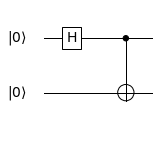

In [100]:
c.plot()

This has roughly the responsibilities and performances that I wanted. 

### Examples taken from the Quipper manual.
As a way to determine whether this idea works at all, I'm going to see what
the various circuits in "An Introduction to Quantum Programming in Quipper" (arXiv 1304.5485) look like. 

Sect 2.1 has the following circuit for *plus_minus*:

In [101]:
def plus_minus(q):
    H(q)

They then define a printing function, which in our system, would consist of:

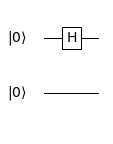

In [102]:
c = QCircuit()
qa,qb = c.zeros('ab')
plus_minus(qa)
c.plot()

We can extend this with the *share* function:

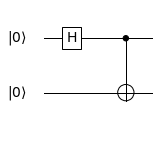

In [103]:
def share(a,b):
    CNOT(a,b)
share(qb,qa)
c.plot()

This captures much of the intent of the original Quipper code in fairly lightweight python.

Actually, I note that the original code didn't have an initialization for the a qubit. This is currently a little more complex, but still do-able:

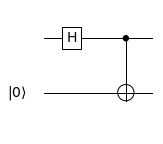

In [104]:
c = QCircuit()
qa = c.qubit('q_a',None)
qb = c.qubit('q_b',0)
plus_minus(qa)
share(qb,qa)
c.plot()


There are still some subtle differences. The 'universe' in the python code where all of the qubits live is explicit, in the form of the quantum circuit, whereas its implicit in the Quipper code. It's not clear to me yet whether this will have any impact on the code flexibility.

One place where this changes things is in the definition of the bell pair code. In Quipper, this is a function without arguments that returns two entangled qubits. We could do this in python as:

In [105]:
def make_bell_pair():
    c = QCircuit()
    a,b = c.zeros('ab')
    H(a)
    CNOT(b,a)
    return a,b

We then return just the qubits, but we can get the circuit from either of them:

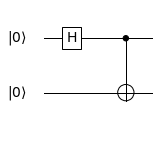

In [106]:
a,b = make_bell_pair()
a.circuit.plot()

We could equivalently make a .plot() function for the qubit that would do the same, or a .get_circuit() function that would return the circuit in a way that has a better separation of the interface from the implementation.

However, I'm going to stick with what I'm doing, which is to have all qubits be allocated at the top level from the circuit, until the wheels fall off:

In [107]:
def bell(a,b):
    H(a)
    CNOT(b,a)
    return

### Measurement
Measurement is something of a problem. We will simply return the qubit reference after measurement. Currently the circuit plotter just doubles all of the qubit lines after a measurement operation (which is a hack, defined as an operation that starts with 'M'). Ideally, the Qubit object itself should 'know' that it has been measured. Distinguishing between quantum, classical and boolean states is something that Quipper does well.

In [108]:
def alice(q,a):
    CNOT(a,q)
    H(q)
    M(q)
    M(a)
    return q,a

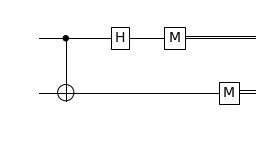

In [109]:
c = QCircuit()
a,b = c.qubits('a',None,'b',None)
alice(a,b)
c.plot()

In [110]:
CZ = Gate('CZ')
CX = Gate('CX')
def bob(b,x,y):
    CX(b,y)
    CZ(b,x)
    return
    

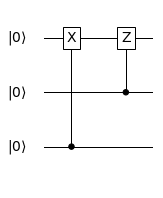

In [111]:
c = QCircuit()
b,x,y = c.qubits('b',0,'x',0,'y',0)
bob(b,x,y)
c.plot()

In [112]:
def teleport(q,a,b):
    bell(a,b)
    x,y = alice(q,a)
    bob(b,x,y)
    return b

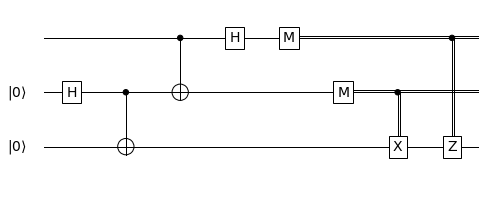

In [113]:
c = QCircuit()
q = c.qubit('q',None)
a,b = c.qubits('a',0,'b',0)
teleport(q,a,b)
c.plot()

Now that we've abstracted the teleportation circuit, we can apply it to multiple qubits:

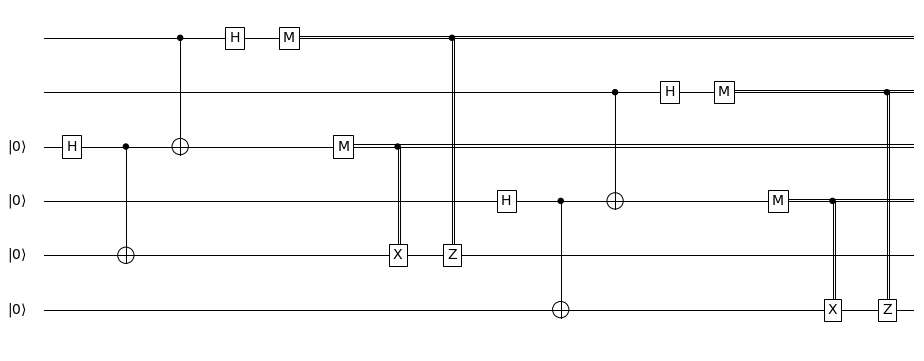

In [114]:
c = QCircuit()
q,q2,a,a2,b,b2 = c.qubits('q',None,'q2',None,'a',0,'a2',0,'b',0,'b2',0)
teleport(q,a,b)
teleport(q2,a2,b2)
c.plot()

## QFT
It's fairly straightforward to create circuits for QFTs:

In [115]:
def qft(*qs):
    for i,q in enumerate(qs):
        for j in range(i):
            CR[i-j+1](qs[j],q)
        H(q)
    return qs
        

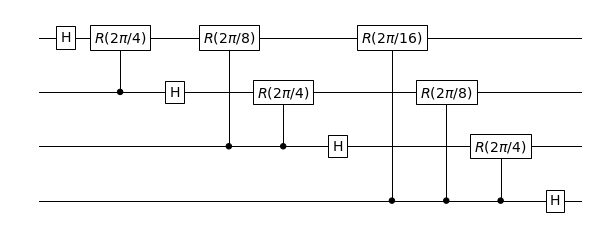

In [116]:
qc = QCircuit()
a,b,c,d = qc.qubits('a',None,'b',None,'c',None,'d',None)
qft(a,b,c,d)
qc.plot()